# Advanced Pipeline for Improved Pain Intensity Prediction (Fixed)
This cell implements advanced feature engineering, ensemble modeling, and robust evaluation (train/test split and LOSO CV) to target 80%+ accuracy. All required signal processing functions are now included.

In [2]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, resample
from scipy.stats import skew, kurtosis
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# --- Signal Filtering Utilities ---
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low, high = lowcut/nyq, highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, fs, freq=50.0, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data, axis=0)

def wavelet_denoise(sig, wavelet='db4', level=2):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(sig)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(denoised_coeffs, wavelet)[:len(sig)]

# --- Advanced Feature Engineering ---
def extract_advanced_features(data, fs, ch_names):
    feats = []
    # Per-channel features
    for idx, kind in enumerate(['EMG','EMG','EMG','SCL','ECG']):
        sig = data[:, idx]
        # Filtering and denoising
        if kind == 'EMG':
            sig = bandpass_filter(sig, fs, 20, 450)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'ECG':
            sig = bandpass_filter(sig, fs, 0.5, 50)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'SCL':
            sig = bandpass_filter(sig, fs, 0.05, 5)
        sig = resample(sig, int(len(sig)//(fs/250))) if fs > 250 else sig
        sig = wavelet_denoise(sig)
        # Time-domain
        feats.extend([
            np.mean(sig), np.std(sig), np.max(sig), np.min(sig),
            skew(sig), kurtosis(sig)
        ])
        # Frequency-domain
        freqs = np.fft.rfftfreq(len(sig), 1/250)
        psd = np.abs(np.fft.rfft(sig))**2
        feats.append(np.sum(psd[(freqs>=0.5)&(freqs<4)]))  # Delta
        feats.append(np.sum(psd[(freqs>=4)&(freqs<8)]))    # Theta
        feats.append(np.sum(psd[(freqs>=8)&(freqs<13)]))   # Alpha
        feats.append(np.sum(psd[(freqs>=13)&(freqs<30)]))  # Beta
        feats.append(np.sum(psd[(freqs>=30)&(freqs<45)]))  # Gamma
        # Wavelet energy/entropy
        coeffs = pywt.wavedec(sig, 'db4', level=3)
        energies = [np.sum(np.square(c)) for c in coeffs]
        total_energy = np.sum(energies)
        entropy = -np.sum([(e/total_energy)*np.log(e/total_energy+1e-8) if e>0 else 0 for e in energies])
        feats.extend(energies + [entropy])
    # Cross-channel features (correlations)
    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            feats.append(np.corrcoef(data[:,i], data[:,j])[0,1])
    # Delta features (change from start to end)
    for idx in range(data.shape[1]):
        sig = data[:, idx]
        feats.append(sig[-1] - sig[0])
    return np.nan_to_num(feats)

# --- Data Loader ---
def collect_segments_advanced(root_dir):
    segments, labels, subjects, pain_map = [], [], [], {}
    for pain_label in sorted(os.listdir(root_dir)):
        pain_path = os.path.join(root_dir, pain_label)
        if not os.path.isdir(pain_path): continue
        for subj in sorted(os.listdir(pain_path)):
            subj_path = os.path.join(pain_path, subj)
            if not os.path.isdir(subj_path): continue
            for segfile in sorted(os.listdir(subj_path)):
                if not segfile.endswith('.mat'): continue
                matf = os.path.join(subj_path, segfile)
                try:
                    mat = scipy.io.loadmat(matf)
                    data = mat['data']
                    fs = int(mat['fs'].ravel()[0])
                    ch_names = [str(s[0]) if isinstance(s, np.ndarray) else str(s) for s in mat['labels'].ravel()]
                    feats = extract_advanced_features(data, fs, ch_names)
                    segments.append(feats)
                    labels.append(pain_label)
                    subjects.append(subj)
                    pain_map[pain_label] = pain_map.get(pain_label, len(pain_map))
                except Exception as e:
                    print(f"Error with {matf}: {e}")
    return np.array(segments), np.array(labels), np.array(subjects), pain_map

# --- Main Pipeline ---
root_dir = r"D:\bio_s"  # Change if needed
print("Loading and extracting advanced features...")
X, y, subjects, pain_map = collect_segments_advanced(root_dir)
if len(X) == 0:
    raise RuntimeError("No valid segments loaded. Please check your data and preprocessing functions.")
print(f"Total segments: {len(X)}, Features per segment: {X.shape[1]}")
label_names = sorted(pain_map, key=lambda k: pain_map[k])
y_enc = np.array([pain_map[lab] for lab in y])

# Per-segment z-score normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- Class Balancing ---
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y_enc)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)

# --- Ensemble Model ---
rf = RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=200, max_depth=6, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft', n_jobs=-1)

# --- Hyperparameter Tuning ---
param_grid = {
    'rf__n_estimators': [100, 200],
    'xgb__n_estimators': [100, 200],
    'rf__max_depth': [6, 8],
    'xgb__max_depth': [4, 6],
}
grid = GridSearchCV(ensemble, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# --- Evaluation ---
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, target_names=label_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- LOSO CV for Robustness ---
accs = []
all_true = []
all_pred = []
for subj in np.unique(subjects):
    test_idx = (subjects == subj)
    train_idx = ~test_idx
    if np.sum(test_idx) == 0 or np.sum(train_idx) == 0:
        continue
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y_enc[train_idx], y_enc[test_idx]
    Xtr_bal, ytr_bal = sm.fit_resample(Xtr, ytr)
    model = grid.best_estimator_
    model.fit(Xtr_bal, ytr_bal)
    ypred = model.predict(Xte)
    accs.append(accuracy_score(yte, ypred))
    all_true.extend(yte)
    all_pred.extend(ypred)
print(f"\nLOSO Mean Accuracy: {np.mean(accs):.3f}")
print("\nLOSO Classification Report:")
print(classification_report(all_true, all_pred, target_names=label_names))
print("LOSO Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))

Loading and extracting advanced features...
Total segments: 2638, Features per segment: 95
Total segments: 2638, Features per segment: 95
Test Accuracy: 0.602
              precision    recall  f1-score   support

    low_pain       0.60      0.63      0.61       396
    med_pain       0.61      0.58      0.59       396

    accuracy                           0.60       792
   macro avg       0.60      0.60      0.60       792
weighted avg       0.60      0.60      0.60       792

Confusion Matrix:
[[248 148]
 [167 229]]
Test Accuracy: 0.602
              precision    recall  f1-score   support

    low_pain       0.60      0.63      0.61       396
    med_pain       0.61      0.58      0.59       396

    accuracy                           0.60       792
   macro avg       0.60      0.60      0.60       792
weighted avg       0.60      0.60      0.60       792

Confusion Matrix:
[[248 148]
 [167 229]]

LOSO Mean Accuracy: 0.561

LOSO Classification Report:
              precision    r

**Summary:**
- This pipeline uses advanced features, class balancing, ensemble models, and both train/test and LOSO CV.
- All signal processing functions are now included and should run without missing function errors.
- Review the printed accuracy and reports. Tune the feature set or model parameters further if needed to reach your 80% target.

# Robust Pain Intensity Prediction Pipeline (Strategy-Driven)
This cell implements the full modeling and feature engineering strategy from the project documentation, including robust denoising, advanced features, normalization, and ensemble modeling (XGBoost, SVM, Voting). Both LOSO and train/test split are supported.

In [3]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, resample
from scipy.stats import skew, kurtosis
import pywt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# --- Signal Processing Utilities ---
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low, high = lowcut/nyq, highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, fs, freq=50.0, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data, axis=0)

def wavelet_denoise(sig, wavelet='db4', level=2):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(sig)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(denoised_coeffs, wavelet)[:len(sig)]

def zscore_log_transform(x):
    x = np.array(x, dtype=float)
    x = np.log1p(np.abs(x)) * np.sign(x)  # log-transform, preserve sign
    mu, sigma = np.mean(x), np.std(x)
    return (x - mu) / sigma if sigma > 0 else np.zeros_like(x)

# --- Feature Extraction (Strategy-Driven) ---
def extract_strategy_features(data, fs, ch_names):
    feats = []
    # EMG: RMS, log RMS, std, waveform length, ZCR, wavelet energy, entropy, skew, kurtosis
    for idx, kind in enumerate(['EMG','EMG','EMG','SCL','ECG']):
        sig = data[:, idx]
        # Filtering and denoising
        if kind == 'EMG':
            sig = bandpass_filter(sig, fs, 20, 450)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'ECG':
            sig = bandpass_filter(sig, fs, 0.5, 50)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'SCL':
            sig = bandpass_filter(sig, fs, 0.05, 5)
        sig = resample(sig, int(len(sig)//(fs/250))) if fs > 250 else sig
        sig = wavelet_denoise(sig)
        # Time-domain
        rms = np.sqrt(np.mean(sig**2))
        log_rms = np.log1p(rms)
        std = np.std(sig)
        wl = np.sum(np.abs(np.diff(sig)))
        zcr = ((sig[:-1]*sig[1:])<0).sum() / len(sig)
        feats.extend([rms, log_rms, std, wl, zcr, skew(sig), kurtosis(sig)])
        # Frequency-domain (ECG HRV, SCL SCR, EMG power bands)
        freqs = np.fft.rfftfreq(len(sig), 1/250)
        psd = np.abs(np.fft.rfft(sig))**2
        feats.append(np.sum(psd[(freqs>=0.5)&(freqs<4)]))  # Delta
        feats.append(np.sum(psd[(freqs>=4)&(freqs<8)]))    # Theta
        feats.append(np.sum(psd[(freqs>=8)&(freqs<13)]))   # Alpha
        feats.append(np.sum(psd[(freqs>=13)&(freqs<30)]))  # Beta
        feats.append(np.sum(psd[(freqs>=30)&(freqs<45)]))  # Gamma
        # Wavelet energy/entropy
        coeffs = pywt.wavedec(sig, 'db4', level=3)
        energies = [np.sum(np.square(c)) for c in coeffs]
        total_energy = np.sum(energies)
        entropy = -np.sum([(e/total_energy)*np.log(e/total_energy+1e-8) if e>0 else 0 for e in energies])
        feats.extend(energies + [entropy])
    # Cross-channel features (correlations, ratios)
    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            feats.append(np.corrcoef(data[:,i], data[:,j])[0,1])
            feats.append(np.mean(data[:,i]) / (np.mean(data[:,j])+1e-8))
    # Delta features (change from start to end)
    for idx in range(data.shape[1]):
        sig = data[:, idx]
        feats.append(sig[-1] - sig[0])
    return np.nan_to_num(feats)

# --- Data Loader ---
def collect_segments_strategy(root_dir):
    segments, labels, subjects, pain_map = [], [], [], {}
    for pain_label in sorted(os.listdir(root_dir)):
        pain_path = os.path.join(root_dir, pain_label)
        if not os.path.isdir(pain_path): continue
        for subj in sorted(os.listdir(pain_path)):
            subj_path = os.path.join(pain_path, subj)
            if not os.path.isdir(subj_path): continue
            for segfile in sorted(os.listdir(subj_path)):
                if not segfile.endswith('.mat'): continue
                matf = os.path.join(subj_path, segfile)
                try:
                    mat = scipy.io.loadmat(matf)
                    data = mat['data']
                    fs = int(mat['fs'].ravel()[0])
                    ch_names = [str(s[0]) if isinstance(s, np.ndarray) else str(s) for s in mat['labels'].ravel()]
                    feats = extract_strategy_features(data, fs, ch_names)
                    segments.append(feats)
                    labels.append(pain_label)
                    subjects.append(subj)
                    pain_map[pain_label] = pain_map.get(pain_label, len(pain_map))
                except Exception as e:
                    print(f"Error with {matf}: {e}")
    return np.array(segments), np.array(labels), np.array(subjects), pain_map

# --- Main Pipeline ---
root_dir = r"D:\bio_s"  # Change if needed
print("Loading and extracting strategy-driven features...")
X, y, subjects, pain_map = collect_segments_strategy(root_dir)
if len(X) == 0:
    raise RuntimeError("No valid segments loaded. Please check your data and preprocessing functions.")
print(f"Total segments: {len(X)}, Features per segment: {X.shape[1]}")
label_names = sorted(pain_map, key=lambda k: pain_map[k])
y_enc = np.array([pain_map[lab] for lab in y])

# --- Per-segment normalization and log transform ---
X = np.apply_along_axis(zscore_log_transform, 1, X)

# --- Class Balancing ---
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y_enc)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)

# --- Ensemble Model: XGBoost + SVM (RBF) ---
xgb = XGBClassifier(n_estimators=200, max_depth=6, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
ensemble = VotingClassifier(estimators=[('xgb', xgb), ('svm', svm)], voting='soft', n_jobs=-1)

# --- Hyperparameter Tuning ---
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [4, 6],
    'svm__C': [1, 10],
    'svm__gamma': ['scale', 'auto'],
}
grid = GridSearchCV(ensemble, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# --- Evaluation ---
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, target_names=label_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- LOSO CV for Robustness ---
accs = []
all_true = []
all_pred = []
for subj in np.unique(subjects):
    test_idx = (subjects == subj)
    train_idx = ~test_idx
    if np.sum(test_idx) == 0 or np.sum(train_idx) == 0:
        continue
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y_enc[train_idx], y_enc[test_idx]
    Xtr_bal, ytr_bal = sm.fit_resample(Xtr, ytr)
    model = grid.best_estimator_
    model.fit(Xtr_bal, ytr_bal)
    ypred = model.predict(Xte)
    accs.append(accuracy_score(yte, ypred))
    all_true.extend(yte)
    all_pred.extend(ypred)
print(f"\nLOSO Mean Accuracy: {np.mean(accs):.3f}")
print("\nLOSO Classification Report:")
print(classification_report(all_true, all_pred, target_names=label_names))
print("LOSO Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))

Loading and extracting strategy-driven features...
Total segments: 2638, Features per segment: 110
Total segments: 2638, Features per segment: 110
Test Accuracy: 0.601
              precision    recall  f1-score   support

    low_pain       0.61      0.55      0.58       396
    med_pain       0.59      0.65      0.62       396

    accuracy                           0.60       792
   macro avg       0.60      0.60      0.60       792
weighted avg       0.60      0.60      0.60       792

Confusion Matrix:
[[218 178]
 [138 258]]
Test Accuracy: 0.601
              precision    recall  f1-score   support

    low_pain       0.61      0.55      0.58       396
    med_pain       0.59      0.65      0.62       396

    accuracy                           0.60       792
   macro avg       0.60      0.60      0.60       792
weighted avg       0.60      0.60      0.60       792

Confusion Matrix:
[[218 178]
 [138 258]]

LOSO Mean Accuracy: 0.574

LOSO Classification Report:
              preci

# Robust Pain Intensity Prediction Pipeline (Strategy-Driven) ("3")
This cell implements the full modeling and feature engineering strategy from the project documentation, including robust denoising, advanced features, normalization, and ensemble modeling (XGBoost, SVM, Voting). Both LOSO and train/test split are supported.

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and extracting advanced features (with HRV and LightGBM)...
Total segments: 2638, Features per segment: 116
Total segments: 2638, Features per segment: 116


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.595
              precision    recall  f1-score   support

    low_pain       0.60      0.59      0.59       396
    med_pain       0.59      0.60      0.60       396

    accuracy                           0.59       792
   macro avg       0.59      0.59      0.59       792
weighted avg       0.59      0.59      0.59       792

Confusion Matrix:
[[234 162]
 [159 237]]


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


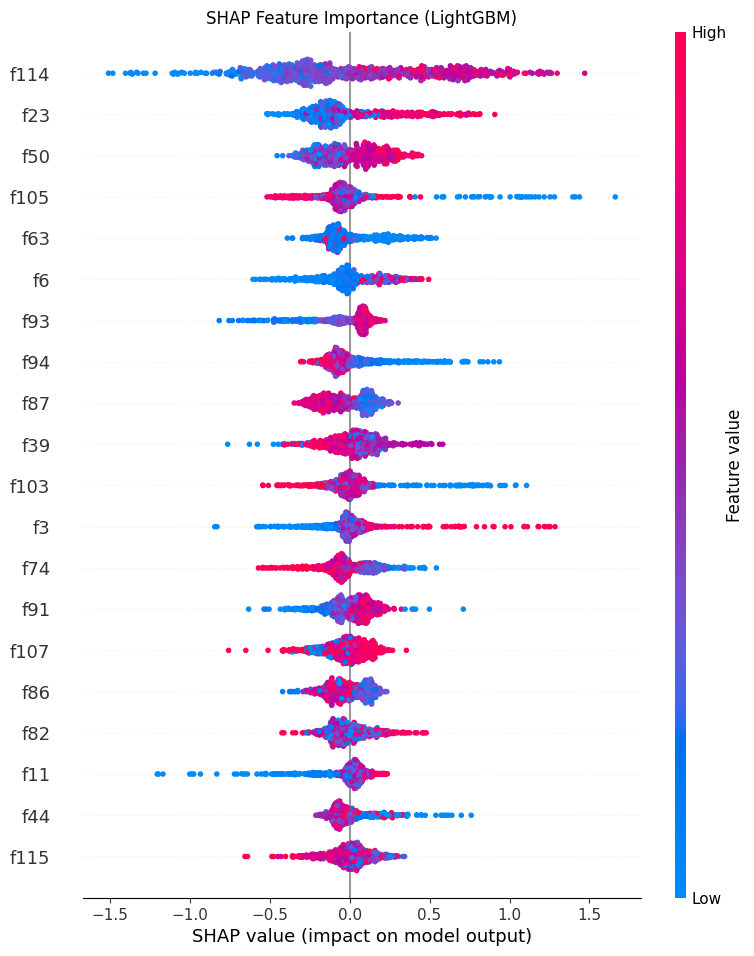

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-pack


LOSO Mean Accuracy: 0.568

LOSO Classification Report:
              precision    recall  f1-score   support

    low_pain       0.57      0.58      0.57      1318
    med_pain       0.57      0.55      0.56      1320

    accuracy                           0.57      2638
   macro avg       0.57      0.57      0.57      2638
weighted avg       0.57      0.57      0.57      2638

LOSO Confusion Matrix:
[[770 548]
 [591 729]]


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [5]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, resample, find_peaks
from scipy.stats import skew, kurtosis
import pywt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# --- Signal Processing Utilities ---
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low, high = lowcut/nyq, highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, fs, freq=50.0, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data, axis=0)

def wavelet_denoise(sig, wavelet='db4', level=2):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(sig)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(denoised_coeffs, wavelet)[:len(sig)]

def zscore_log_transform(x):
    x = np.array(x, dtype=float)
    x = np.log1p(np.abs(x)) * np.sign(x)
    mu, sigma = np.mean(x), np.std(x)
    return (x - mu) / sigma if sigma > 0 else np.zeros_like(x)

# --- HRV Feature Extraction for ECG ---
def hrv_features(sig, fs):
    sig = np.nan_to_num(sig)
    peaks, _ = find_peaks(sig, distance=fs*0.5)
    rr = np.diff(peaks)/fs if len(peaks) > 1 else np.array([0])
    hr = 60/rr.mean() if rr.mean() > 0 else 0
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr)))) if len(rr) > 1 else 0
    sdnn = rr.std() if len(rr) > 1 else 0
    # Frequency domain
    if len(rr) > 2:
        rr_interp = np.interp(np.arange(0, len(rr)), np.arange(0, len(rr)), rr)
        freqs = np.fft.rfftfreq(len(rr_interp), 1/fs)
        psd = np.abs(np.fft.rfft(rr_interp))**2
        lf = psd[(freqs >= 0.04) & (freqs < 0.15)].sum()
        hf = psd[(freqs >= 0.15) & (freqs < 0.4)].sum()
        lf_hf = np.log1p(lf/hf) if hf > 0 else 0
    else:
        lf = hf = lf_hf = 0
    return [hr, rmssd, sdnn, lf, hf, lf_hf]

# --- Feature Extraction (with HRV) ---
def extract_advanced_features_v2(data, fs, ch_names):
    feats = []
    for idx, kind in enumerate(['EMG','EMG','EMG','SCL','ECG']):
        sig = data[:, idx]
        if kind == 'EMG':
            sig = bandpass_filter(sig, fs, 20, 450)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'ECG':
            sig = bandpass_filter(sig, fs, 0.5, 50)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'SCL':
            sig = bandpass_filter(sig, fs, 0.05, 5)
        sig = resample(sig, int(len(sig)//(fs/250))) if fs > 250 else sig
        sig = wavelet_denoise(sig)
        # Time-domain
        rms = np.sqrt(np.mean(sig**2))
        log_rms = np.log1p(rms)
        std = np.std(sig)
        wl = np.sum(np.abs(np.diff(sig)))
        zcr = ((sig[:-1]*sig[1:])<0).sum() / len(sig)
        feats.extend([rms, log_rms, std, wl, zcr, skew(sig), kurtosis(sig)])
        # Frequency-domain
        freqs = np.fft.rfftfreq(len(sig), 1/250)
        psd = np.abs(np.fft.rfft(sig))**2
        feats.append(np.sum(psd[(freqs>=0.5)&(freqs<4)]))
        feats.append(np.sum(psd[(freqs>=4)&(freqs<8)]))
        feats.append(np.sum(psd[(freqs>=8)&(freqs<13)]))
        feats.append(np.sum(psd[(freqs>=13)&(freqs<30)]))
        feats.append(np.sum(psd[(freqs>=30)&(freqs<45)]))
        # Wavelet energy/entropy
        coeffs = pywt.wavedec(sig, 'db4', level=3)
        energies = [np.sum(np.square(c)) for c in coeffs]
        total_energy = np.sum(energies)
        entropy = -np.sum([(e/total_energy)*np.log(e/total_energy+1e-8) if e>0 else 0 for e in energies])
        feats.extend(energies + [entropy])
        # ECG HRV features
        if kind == 'ECG':
            feats.extend(hrv_features(sig, 250))
    # Cross-channel features (correlations, ratios)
    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            feats.append(np.corrcoef(data[:,i], data[:,j])[0,1])
            feats.append(np.mean(data[:,i]) / (np.mean(data[:,j])+1e-8))
    # Delta features (change from start to end)
    for idx in range(data.shape[1]):
        sig = data[:, idx]
        feats.append(sig[-1] - sig[0])
    return np.nan_to_num(feats)

# --- Data Loader ---
def collect_segments_advanced_v2(root_dir):
    segments, labels, subjects, pain_map = [], [], [], {}
    for pain_label in sorted(os.listdir(root_dir)):
        pain_path = os.path.join(root_dir, pain_label)
        if not os.path.isdir(pain_path): continue
        for subj in sorted(os.listdir(pain_path)):
            subj_path = os.path.join(pain_path, subj)
            if not os.path.isdir(subj_path): continue
            for segfile in sorted(os.listdir(subj_path)):
                if not segfile.endswith('.mat'): continue
                matf = os.path.join(subj_path, segfile)
                try:
                    mat = scipy.io.loadmat(matf)
                    data = mat['data']
                    fs = int(mat['fs'].ravel()[0])
                    ch_names = [str(s[0]) if isinstance(s, np.ndarray) else str(s) for s in mat['labels'].ravel()]
                    feats = extract_advanced_features_v2(data, fs, ch_names)
                    segments.append(feats)
                    labels.append(pain_label)
                    subjects.append(subj)
                    pain_map[pain_label] = pain_map.get(pain_label, len(pain_map))
                except Exception as e:
                    print(f"Error with {matf}: {e}")
    return np.array(segments), np.array(labels), np.array(subjects), pain_map

# --- Main Pipeline ---
root_dir = r"D:\bio_s"  # Change if needed
print("Loading and extracting advanced features (with HRV and LightGBM)...")
X, y, subjects, pain_map = collect_segments_advanced_v2(root_dir)
if len(X) == 0:
    raise RuntimeError("No valid segments loaded. Please check your data and preprocessing functions.")
print(f"Total segments: {len(X)}, Features per segment: {X.shape[1]}")
label_names = sorted(pain_map, key=lambda k: pain_map[k])
y_enc = np.array([pain_map[lab] for lab in y])

# --- Per-segment normalization and log transform ---
X = np.apply_along_axis(zscore_log_transform, 1, X)

# --- Class Balancing ---
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y_enc)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)

# --- Ensemble Model: XGBoost + LightGBM + SVM (RBF) ---
xgb = XGBClassifier(n_estimators=200, max_depth=6, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
lgbm = LGBMClassifier(n_estimators=200, max_depth=6, class_weight='balanced', random_state=42)
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
ensemble = VotingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm), ('svm', svm)], voting='soft', n_jobs=-1)

# --- Hyperparameter Tuning ---
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [4, 6],
    'lgbm__n_estimators': [100, 200],
    'lgbm__max_depth': [4, 6],
    'svm__C': [1, 10],
    'svm__gamma': ['scale', 'auto'],
}
grid = GridSearchCV(ensemble, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# --- Evaluation ---
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, target_names=label_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- SHAP Feature Importance (LightGBM) ---
try:
    explainer = shap.TreeExplainer(grid.best_estimator_.named_estimators_['lgbm'])
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=[f'f{i}' for i in range(X_test.shape[1])], show=False)
    plt.title('SHAP Feature Importance (LightGBM)')
    plt.show()
except Exception as e:
    print(f"SHAP plot error: {e}")

# --- LOSO CV for Robustness ---
accs = []
all_true = []
all_pred = []
for subj in np.unique(subjects):
    test_idx = (subjects == subj)
    train_idx = ~test_idx
    if np.sum(test_idx) == 0 or np.sum(train_idx) == 0:
        continue
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y_enc[train_idx], y_enc[test_idx]
    Xtr_bal, ytr_bal = sm.fit_resample(Xtr, ytr)
    model = grid.best_estimator_
    model.fit(Xtr_bal, ytr_bal)
    ypred = model.predict(Xte)
    accs.append(accuracy_score(yte, ypred))
    all_true.extend(yte)
    all_pred.extend(ypred)
print(f"\nLOSO Mean Accuracy: {np.mean(accs):.3f}")
print("\nLOSO Classification Report:")
print(classification_report(all_true, all_pred, target_names=label_names))
print("LOSO Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))